In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from numba import jit, vectorize, float64, int64

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
!pip install --index-url https://test.pypi.org/simple/ presnie

Looking in indexes: https://test.pypi.org/simple/


In [2]:
from algorithm import sghmc

In [6]:
def gradlogistic(X,Y,theta,n,V):  
    #theta is updated
    #X,Y are samples from the minibatch
    #n is total number of observations
    #V should be provided ahead, specified here
    Vinv = np.linalg.inv(V)
    d1 = -np.diag(Y-1/(1+np.exp(-X@theta)))@X
    d2 = Vinv@theta
    d1_avg = d1.mean(axis = 0)
    return d1_avg*n + d2

In [7]:
def test_err(theta,X_test,Y_test):
    err = []
    for i in points:
        pro = 1/(1+np.exp(-(X_test @ theta[:i,:].T)))
        pred = np.random.binomial(1,pro)
        coverage = np.mean(pred == Y_test[:,None])
        err.append(1-coverage)
    return(err)

## Data Preparation

In [8]:
df = pd.read_csv("HEART.csv")

In [9]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


### Missing value

In [10]:
df.isna().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [11]:
df.education = df.education.fillna(df.education.median(skipna=True))
df.cigsPerDay = df.cigsPerDay.fillna(df.cigsPerDay.median(skipna = True))
df.BPMeds = df.BPMeds.fillna(df.BPMeds.median(skipna=True))
df.totChol = df.totChol.fillna(df.totChol.median(skipna=True))
df.BMI = df.BMI.fillna(df.BMI.median(skipna=True))
df.heartRate = df.heartRate.fillna(df.heartRate.median(skipna=True))
df.glucose = df.glucose.fillna(df.glucose.median(skipna=True))

In [12]:
df.isna().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

## Analysis

### Error rate

In [13]:
Y = np.array(df[["TenYearCHD"]]).ravel()

In [14]:
X = df[['age','male','cigsPerDay','totChol','sysBP','glucose']]

In [15]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.20,random_state=5)

#### Logistic Model

In [16]:
#unscaled
logreg=LogisticRegression(fit_intercept = False)
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

In [17]:
sum(y_pred == y_test)/y_test.shape[0]

0.8278301886792453

#### SGHMC

In [18]:
theta0 = np.zeros(X.shape[1])
M = C = np.eye(X.shape[1])
nbatch=500
eps=.001
V = np.eye(X.shape[1])

In [19]:
sghmc_theta = sghmc.sghmc(theta0,np.array(x_train),y_train,nbatch,gradlogistic,M,C,V,eps,1000,40)

In [20]:
points = np.arange(1,1000,100)
#take the first 1000 iteration

In [21]:
1-np.mean(test_err(sghmc_theta,x_test,y_test))

0.7599922306940701

### Theta Value (Scaled X)

In [22]:
#scaled
Xs = (X-np.mean(X,axis = 0))/np.std(X,axis = 0)

In [23]:
x_train,x_test,y_train,y_test=train_test_split(Xs,Y,test_size=.2, random_state = 5)

#### Logistic Model

In [24]:
logreg=LogisticRegression(fit_intercept = False)
logreg.fit(x_train,y_train)
y_pred=logreg.predict(x_test)

In [25]:
logreg.coef_

array([[ 0.27024713,  0.09876673,  0.12726637, -0.00558637,  0.19267253,
         0.14713648]])

#### SGHMC

In [26]:
theta0 = np.zeros(X.shape[1])
M = C = np.eye(X.shape[1])
nbatch=500
eps=.001
V = np.eye(X.shape[1])

In [27]:
sghmc_theta = sghmc.sghmc(theta0,np.array(x_train),y_train,nbatch,gradlogistic,M,C,V,eps,1000,40)

In [28]:
sghmc_theta.mean(axis = 0)

array([ 0.27715559,  0.09806301,  0.13100113, -0.0077804 ,  0.18745623,
        0.15248501])

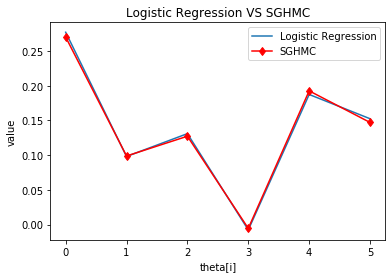

In [29]:
x_axis = np.arange(0,6,1)

plt.plot(x_axis, sghmc_theta.mean(axis = 0))
plt.plot(x_axis, logreg.coef_.ravel(),"d-",color = 'red')
plt.legend(["Logistic Regression", "SGHMC"])
plt.xlabel("theta[i]")
plt.ylabel("value")
plt.title("Logistic Regression VS SGHMC")
plt.savefig("Logistic Regression VS SGHMC")